# Processing the results of the motif search

In [1]:
import nengo
import multiprocessing
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hashids import Hashids
from run_motif_search import *
import os
import scipy
from tqdm import tqdm
import networkx as nx


## Function defs

In [386]:
def sin_fit(x, a, b,c,e):
    ret = a * np.sin(b * x + c) + e
    
    return ret

def draw_graph(metadata,ax1=None,ax2=None, colors=['tab:blue', 'tab:orange']):
    mm = metadata[0]
    lr = metadata[1]
    imm = metadata[2]
    # Create the adjacency matrix
    adj = np.zeros((8,8))
    adj[:4, :4] = mm
    adj[4:8, 4:8] = mm
    adj[4:8,:4] = lr
    adj[:4,4:8] = lr
    
    
    imadj = np.zeros((8,8))
    imadj[4:,4:] = imm
    imadj[:4,:4] = imm
    
    
    adj2 = np.zeros((16,16))
    adj2[:8,:8] = adj
    adj2[8:, 8:] = adj
    adj2[:8,8:] = imadj
#     adj2[8:,:8] = imadj
   
    
    
    
    
    
    
    ax2.imshow(adj2, aspect='equal')
    ax2.set_xticks(np.arange(-0.5,15,4), minor=True)
    ax2.set_yticks(np.arange(-0.5,15,4), minor=True)
    ax2.set_xticks([1.75,5.75,9.75,13.75])
    ax2.set_yticks([1.75,5.75,9.75,13.75])
    ax2.set_xticklabels(['M1L' ,'M1R','M2L','M2R'])
    ax2.set_yticklabels(['M1L' ,'M1R','M2L','M2R'])
    ax2.axvline([7.5],color='r', ls='--',lw=2)
    ax2.axhline([7.5],color='r', ls='--', lw=2)
#     ax2.grid(which='minor', color='r', linestyle='--', linewidth=1)
    ax2.grid(which='minor', color='w', linestyle='-', linewidth=1)
    
    
    # Create graph
    G = nx.from_numpy_matrix(adj2, create_using=nx.DiGraph)
    # Draw graph
    node_positions = np.array([
        [-2,1.5], # L1
        [-0.5,0], # L2
        [-2.5,-1], # L3
        [-1,-2], # L4
        [2,1.5], # R1
        [0.5,0], # R2
        [2.5,-1], # R3
        [1,-2] # R4
    ])
    node_positions = np.vstack((node_positions, node_positions))
    node_positions[8:,1] -= 4
    labels = {
        0: 'L1',
        1: 'L2',
        2: 'L3',
        3: 'L4',
        4: 'R1',
        5: 'R2',
        6: 'R3',
        7: 'R4',
        8: 'L1',
        9: 'L2',
        10: 'L3',
        11: 'L4',
        12: 'R1',
        13: 'R2',
        14: 'R3',
        15: 'R4'
    }
    nodecolors = [colors[0]]*8 + [colors[1]]*8
    nx.draw_networkx(G, pos=node_positions,ax=ax1, with_labels=True, labels=labels, node_color=nodecolors )
def process_fn(top,fn, tslc=slice(1000,None)):
    with open(os.path.join(datapath,fn), 'rb') as fp:
        ret = pickle.load(fp)
    
    fig, axs = plt.subplots(1,4,figsize=(12,4))
    ax = axs[0]
    ret['motor_values'] = np.array(ret['motor_values'])
    ax.scatter(ret['time'][tslc], ret['motor_values'][tslc,0], s=0.1, color='tab:blue', alpha=1)
    ax.scatter(ret['time'][tslc], ret['motor_values'][tslc,1], s=0.1, color='tab:orange')
    ax = axs[0]
    params = tuple(top.loc[fn,['a1','b1','c1','e1']])
    print('m1 params: %s' % str(params))
    cov = top.loc[fn, 'cov1']
    err = top.loc[fn,'err1']
    fit = top.loc[fn,'fit1'][0]
#     l1 = ax.plot(ret['time'][tslc],  fit, color='tab:blue', lw=2, alpha=0.2)[0]
    l1 = ax.plot(ret['time'][tslc], sin_fit(np.array(ret['time']).ravel(), *params)[tslc], color='tab:blue', lw=2, alpha=0.2)[0]
    axs[1].scatter(ret['time'][tslc], (ret['motor_values'][tslc,0]  - params[-1])/params[0], s=0.1, color='tab:blue', alpha=1)

    params = tuple(top.loc[fn,['a2','b2','c2','e2']])
    print('m2 params: %s' % str(params))
    cov = top.loc[fn, 'cov2']
    err = top.loc[fn,'err2']
    fit = top.loc[fn,'fit2'][0]
    l2 = ax.plot(ret['time'][tslc], sin_fit(np.array(ret['time']).ravel(), *params)[tslc], color='tab:orange', lw=2, alpha=0.2)[0]
#     l2 = ax.plot(ret['time'][tslc],fit, color='tab:orange', lw=2, alpha=0.2)[0]
    axs[1].scatter(ret['time'][tslc], (ret['motor_values'][tslc,1] - params[-1])/params[0], s=0.1, color='tab:orange')
#     ax.title.set_text("err : {}, params : {}".format(np.round(err,4),np.round(params,2)))
    ax.legend([l1,l2],['M1','M2'])
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    ax = axs[1]
    
    axs[0].title.set_text('Data and fit')
    axs[1].title.set_text('Rescaled data')
    axs[2].title.set_text('Structure')
    axs[3].title.set_text('Adjacency matrix')
                                                   
    
    fig.suptitle('Rank {} Fitness: {:.2f} '.format(top.index.get_loc(fn),top.loc[fn,'fitness']))
    
    draw_graph(ret['_metadata'],axs[2], axs[3])

## Data load

In [409]:
raw_df = pd.read_pickle('sin_fit_results_df_s2.pkl')
datapath = './data_s2'
raw_df['fitness'] = -np.inf
raw_df['phase_diff'] = -np.inf
gtslc = slice(3000,4000)

m1 params: (0.8583459810473593, 16.146007751772682, 9.530797579148265, 0.3922811994279859)
m2 params: (0.8889387162826128, 16.15818544739385, 12.61712294619424, 0.3930851982711777)


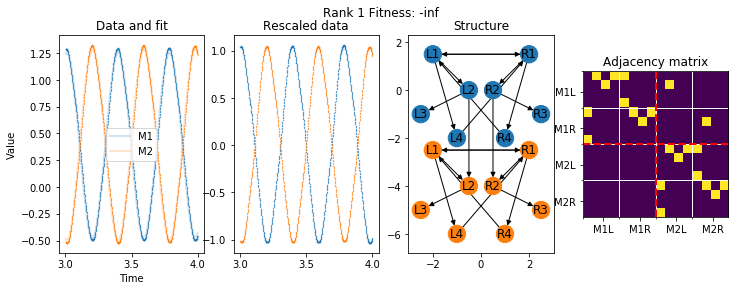

In [410]:
process_fn(raw_df,raw_df.index[1], tslc=gtslc)

## Apply filters

In [411]:
# Filter out small amplitude waves -- usually means that there was no output
df = raw_df.copy()
df = df.query("abs(a1) >= 1e-2 & abs(a2) >= 1e-2")
# Filter out super low frequency waves -- usually bad fit
df = df.query("b1 > 2 & b2 > 2")
# We want the phase difference to be significant
# df = df.query("abs(c1 - c2) > 1")
len(df)

1086

## Evaluate fitness function on parameters and error

In [431]:
target_phase = np.pi/2
print('target_phase : {}'.format(target_phase))
def get_phase_diff(r):
    phase = (r.c1 - r.c2) % (np.pi*2)
    return phase
def get_phase_fitness(r):
    
    fitness = np.abs(r.phase_diff-target_phase)
    return fitness

target_phase : 1.57079632679


In [432]:
# df['fitness'] = df.apply(lambda r: r.err, axis=1)
# df['fitness'] = df.apply(lambda r: r.a, axis=1)
# df['fitness'] = df['err']
df['phase_diff'] = df.apply(get_phase_diff,axis=1)
df['fitness'] = df.apply(get_phase_fitness , axis=1)

In [433]:
fit_sorted = df.sort_values(by='fitness')
top = fit_sorted.head()


## Top performers

m1 params: (0.4186665622795576, 15.416032619426344, 14.906150206041753, -0.8030204336620653)
m2 params: (0.4720760864334454, 16.730267236279524, 7.1074887392706145, -1.3063684955845865)
m1 params: (0.4186665622795576, 15.416032619426344, 14.906150206041753, -0.8030204336620653)
m2 params: (0.4720760864334454, 16.730267236279524, 7.1074887392706145, -1.3063684955845865)
m1 params: (0.12105826737899342, 16.394614451883246, 7.171397800364154, 0.13235431572448522)
m2 params: (0.1337639361986256, 16.058436787120385, 11.801995014523214, 0.13953300014660822)
m1 params: (0.12105826737899342, 16.394614451883246, 7.171397800364154, 0.13235431572448522)
m2 params: (0.1337639361986256, 16.058436787120385, 11.801995014523214, 0.13953300014660822)
m1 params: (0.12105826645746352, 16.394613793748196, 4.0298072742273705, -0.13235431327551542)
m2 params: (0.1337639376436206, 16.05843814091395, 8.660397862628303, -0.13953299554826126)


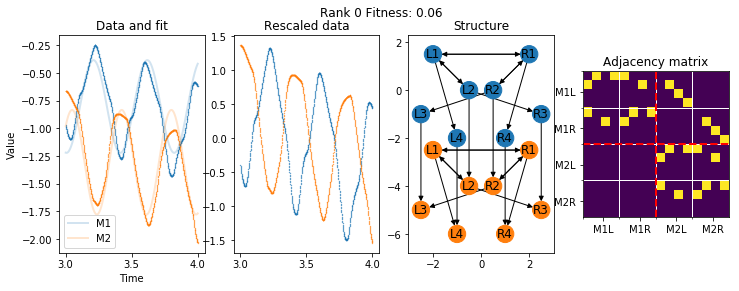

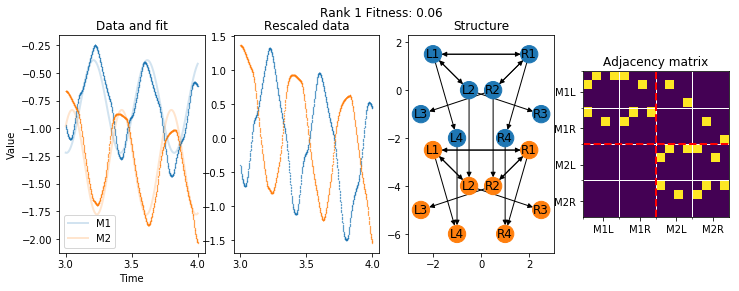

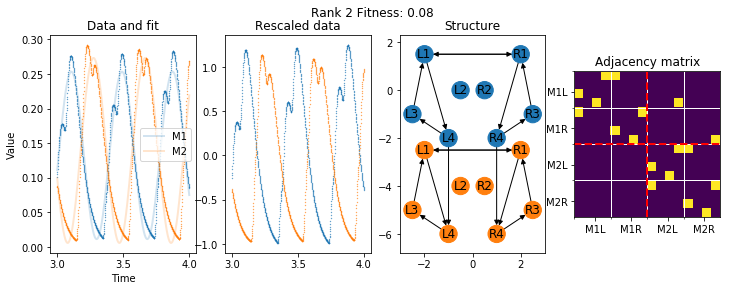

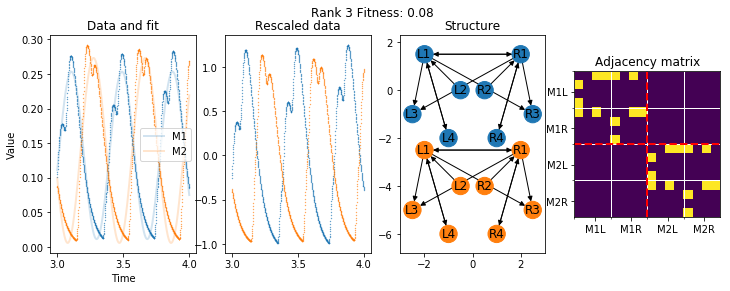

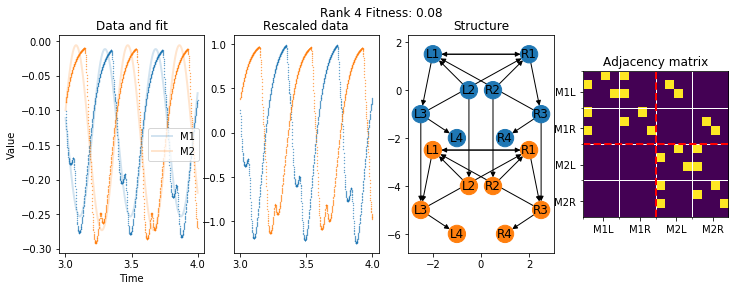

In [434]:
for i,fn in enumerate(top.index):
    process_fn(top,fn, tslc=gtslc)

# Check biological networks

## Leech heartbeat

In [418]:
mm = np.array(
[
    [0,0,0,1],
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
])
lr = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,0,0,0]
])

imm = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr,imm)) + '.pkl'
process_fn(fit_sorted,fn)


IOError: [Errno 2] No such file or directory: './data_s2/qRcPcBcKf7fPcgcwc3crflcjcJcgczfEc5fpcnckcLcwc7cGcMc9cyfLcXc6cNcOcMf6cocYcWcncVcOcDcNcLfQcncVc6cG.pkl'

## Proposed heartbeat

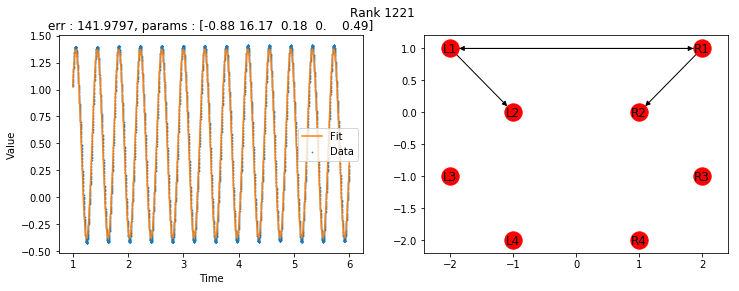

In [31]:
mm = np.array(
[
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])
lr = np.array(
[
    [1,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(fit_sorted,fn)

## C. elegans

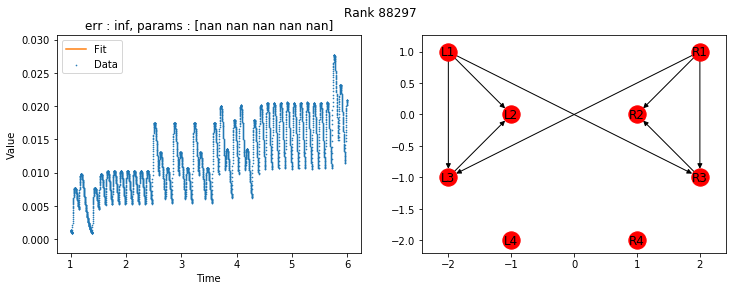

In [39]:
mm = np.array(
[
    [0,1,1,0],
    [0,0,0,0],
    [0,1,0,0],
    [0,0,0,0]
])
lr = np.array(
[
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
])

fn = make_hash((mm,lr)) + '.pkl'
process_fn(fit_sorted,fn)

## Check where fitness starts to increase

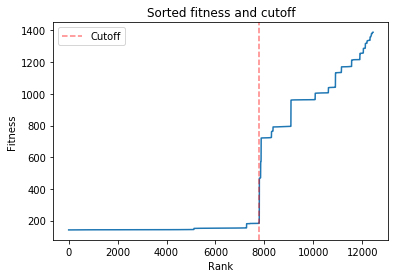

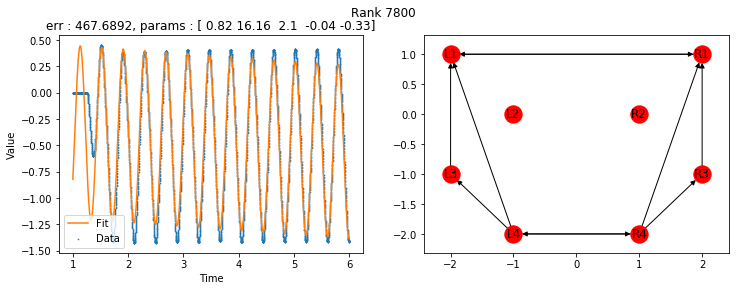

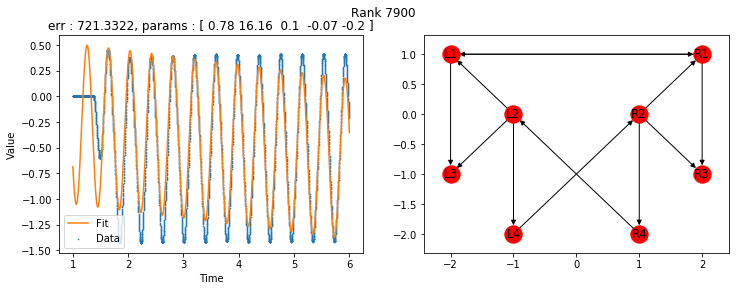

In [37]:
fig, ax = plt.subplots()
ax.plot(fit_sorted['fitness'].to_numpy())
ebreak_idx = 7800
l = ax.axvline(ebreak_idx, ls='--', color='r', alpha=0.5)
ax.set_xlabel('Rank')
ax.set_ylabel('Fitness')
ax.legend([l],['Cutoff'])
ax.title.set_text('Sorted fitness and cutoff')
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx].name)
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx+100].name)

In [44]:
top_n = 100
top = fit_sorted.head(top_n)
def add_metadata(idx):
    with open(os.path.join(datapath,idx), 'rb') as fp:
        ret = pickle.load(fp)
    return [ret['_metadata']]
top['_metadata'] = top.index.map(add_metadata)

top.to_pickle('top_sin_fit_{}'.format(top_n))

/home/raph/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [45]:
top

,err,cov,a,b,c,d,e,fitness,_metadata
nQcqcYcqc7clcGcKfYcWcPcGf6f3c8ckckfNcyc2cqc6cxc0cNcBcncnfycNcrcE.pkl,141.15,"[[[4.047541998623909e-07, 4.951706264643733e-0...",0.876707,16.1703,0.172835,-0.000197886,-0.497841,141.149744,"[([[0 0 0 0], [0 0 0 1], [0 0 0 1], [1 0 0 0]]..."
oRcrfZc8c4cQc1fqcDcOcqcnf7fncQcZcgfLc7cocrcpcVc8cAf1crcjcQc7c6cE.pkl,141.15,"[[[4.047541998623909e-07, 4.951706264643733e-0...",0.876707,16.1703,0.172835,-0.000197886,-0.497841,141.149744,"[([[0 1 0 0], [0 0 1 0], [0 0 0 1], [1 0 0 0]]..."
oRcLc1f8cYfQcWcqcDcOcqcXcOc8fxfZcgfLc7cocrcpcVc8cRc1crcjcQcDf6cE.pkl,141.15,"[[[4.047541998623909e-07, 4.951706264643733e-0...",0.876707,16.1703,0.172835,-0.000197886,-0.497841,141.149744,"[([[0 0 1 0], [1 0 0 0], [0 0 0 0], [0 1 1 0]]..."
oRcLcZcqfYfQcWcqcgfOcqcXcOcncxfZcgfLc7cocrcpcVc8cRc1crcjcQc7cnfE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 1], [1 0 0 0], [1 0 0 0], [0 0 1 0]]..."
oRcLcZcqfYfQcWcqcDcofqcnfOcncQcZcgfLc7cocrcpc1f8cRc1crcjcQc7c6cE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 1], [1 0 0 0], [0 1 0 1], [0 0 0 0]]..."
nQcqcYcqc7clcZfrc9fWcPc0c6f3c8ckckfNcyc2cqc6cxc0cvfBcnc1cycNcrcE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 0], [0 0 1 0], [1 0 0 0], [1 0 0 0]]..."
oRcLcZcqfYfQcWcqcgfOcqcXcOcncxfZcgfLc7cocrcpcVcvfRc1crcjcQc7c6cE.pkl,141.15,"[[[4.0475414293482856e-07, -4.9516859177265105...",-0.876707,16.1703,0.172835,0.000197895,0.497841,141.149745,"[([[0 0 0 1], [1 0 0 0], [1 0 0 0], [0 0 1 0]]..."
oRcLcZc8cYfQcWcWfDcofqcXc7fncQcZcgfLc7cocrcpcVc8cRc1cWfjcQc7c6cE.pkl,141.253,"[[[4.0548236267627825e-07, 4.925110340265985e-...",0.87687,16.1738,0.179878,-0.000642276,-0.49601,141.252509,"[([[0 0 0 0], [1 0 0 1], [0 1 0 0], [1 0 0 0]]..."
oRcLcZc8cYfQcWcWfDcofqcXcOc8fQcZcgfLc7cocrcpcVc8cRc1crcjcQc7cnfE.pkl,141.253,"[[[4.0548236267627825e-07, 4.925110340265985e-...",0.87687,16.1738,0.179878,-0.000642276,-0.49601,141.252509,"[([[0 0 0 0], [1 0 0 1], [0 1 0 0], [0 1 0 0]]..."
kQc6cEcnfAcycVcOcqcmc8coczcMcYczcPf4cPcxc1cvczc0c9cmc1cjcEcycDc9.pkl,141.344,"[[[4.045356257102011e-07, -4.938712368662625e-...",-0.876909,16.1717,0.174993,0.000497592,0.496573,141.343559,"[([[0 0 0 1], [0 0 0 0], [0 0 0 0], [0 0 0 0]]..."
